# TabPFN

Main idea: transformer for a small tabular data, based on Prior-Data Fitted Networks (PFN). PFN uses Bayesian inference given any prior one can sample from and approximate the posterior predictive distribution (PPD) directly. PFN can simply design a dataset-generating algorithm that encodes the desired prior.

Basically, TabPFN on the offline stage is trained on synthetic datasets and learns to determine from which distribution φ<sub>i</sub>: X<sub>i</sub> ~ y<sub>i</sub> each object was sampled. On the online stage TabPFN gets data from the real dataset, represents posterior distribution from which this dataset was sampled as mix of prior distributions φ<sub>i</sub> it was trained, weighted by their likelihood. Then it fits it's hyperparameters (architectures of inner Bayesian Neural Network (BNN) models, weigths, etc.)  according to that posterior data distribution and makes a predictions.


## TabPFN: result

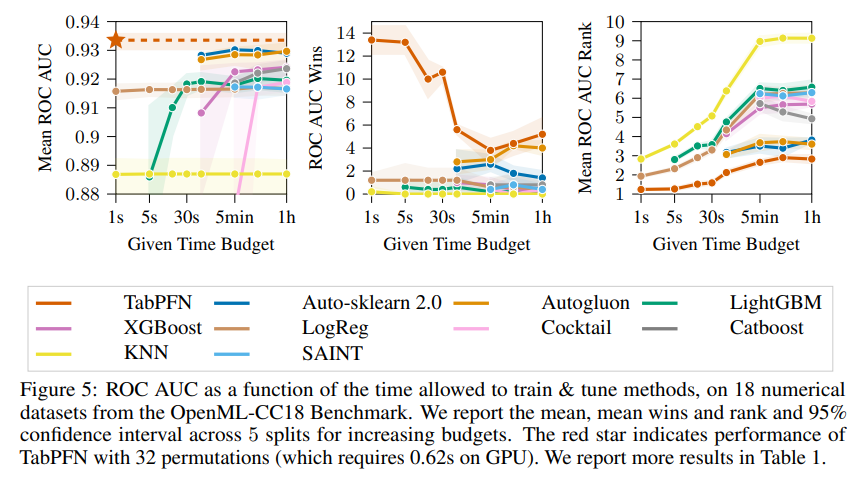

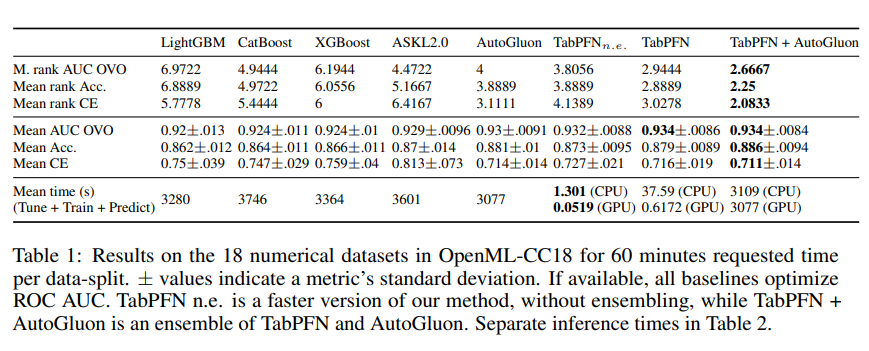

Works badly with Categorical features and NaNs

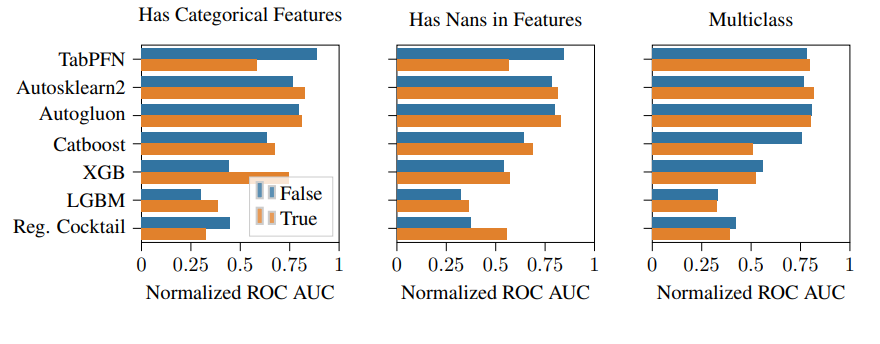

## More detailed explanation of TabPFN

We design a prior based on Bayesian Neural Networks (BNN) and Structural Causal Models (SCM) to model complex feature dependencies and potential causal mechanisms underlying tabular data. Our prior is defined via parametric distributions, e.g., a log-scaled uniform distribution for the average number of nodes in data-generating SCMs. The resulting PPD implicitly models uncertainty over all possible data-generating mechanisms, weighting them by their likelihood given the data and their prior probability. Thus, the PPD corresponds to an infinitely large ensemble of data-generating mechanisms, i.e., instantiations of SCMs and BNNs. We learn to approximate this complex PPD in a single forward-pass, requiring no cross-validation or model selection.

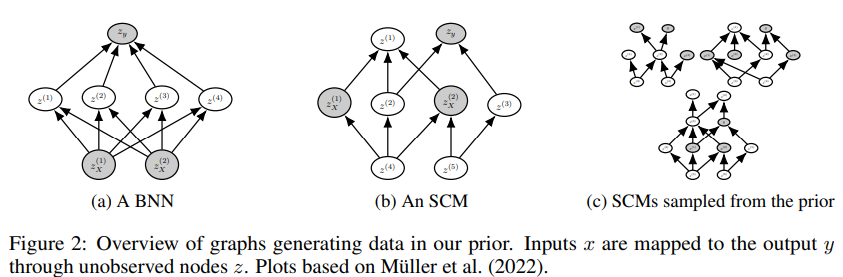

### How Bayesian inference works

In the Bayesian framework for supervised learning, the prior defines a space of hypotheses **Φ** on the relationship of a set of inputs **x** to the output labels **y**. Each hypothesis **φ** ∈ **Φ** can be seen as a mechanism that generates a data distribution from which we can draw samples forming a dataset. In practice, a dataset comprises training data with observed labels and test data where labels are missing or held out. The PPD for a test sample **x<sub>test</sub>** specifies the distribution of its label **p(·|x<sub>test</sub>, D<sub>train</sub>)**, which is conditioned on the set of training samples **D<sub>train</sub> := {(x<sub>1</sub>, y<sub>1</sub>), . . . , (x<sub>n</sub>, y<sub>n</sub>)}**. The PPD can be obtained by integration over the space of hypotheses **Φ**, where the weight of a hypothesis **φ** ∈ **Φ** is determined by its prior probability **p(φ)** and the likelihood **p(D|φ)** of the data D given **φ**:

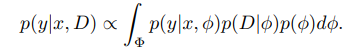

### Prior-fitting

Prior-fitting is the training of a PFN to approximate the PPD and thus do Bayesian prediction. We implement it with a prior which is specified by a prior sampling scheme of the form **p(D) = E<sub>φ∼p(φ)</sub>[p(D|φ)]**, which first samples hypotheses (generating mechanisms) with φ ∼ p(φ) and then synthetic datasets with **D ∼ p(D|φ)**. We repeatedly sample such synthetic datasets **D := (x<sub>i</sub>, y<sub>i</sub>) <sub>i∈{1,...,n}</sub>** and optimize the PFN's parameters **θ** to make predictions for **D<sub>test</sub> ⊂ D**, conditioned on the rest of the dataset **D<sub>train</sub> = D \ D<sub>test</sub>**. The loss of the PFN training thus is the cross-entropy on held-out examples of synthetic datasets. For a single test point **{(x<sub>test</sub>, y<sub>test</sub>)} = D<sub>test</sub>**, the training loss can be written as

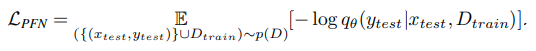

Minimizing this loss approximates the true Bayesian posterior predictive distribution.

### Real-World Inference 

During inference, the trained model is applied to unseen real-world datasets. For a novel dataset with training samples **D<sub>train</sub>** and test features **x<sub>test</sub>**, feeding **<D<sub>train</sub>**, **x<sub>test</sub>>** as an input to the model trained above yields the PPD **q<sub>θ</sub>(y|x<sub>test</sub>, D<sub>train</sub>)** in a single forward-pass. The PPD class probabilities are then used as predictions for our real-world task.

We visualize this in the image below:

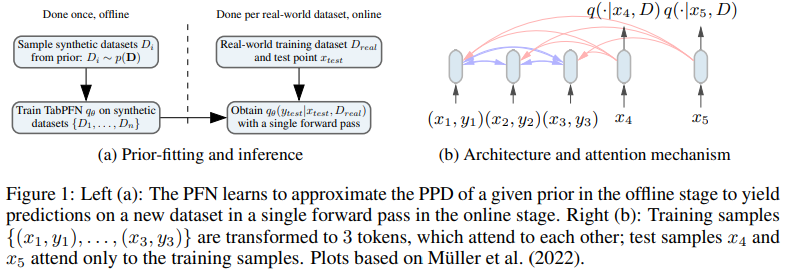

### Inference

During inference, the TabPFN approximates the PPD for our dataset prior, i.e., it approximates the marginal predictions across our spaces of SCMs and BNNs, including a bias towards simple and causal explanations for the data. In our experiments, we present predictions for a single forward pass of our TabPFN, as well as predictions that ensemble 32 forward passes of datasets modified by a power transformation (applied with probability 0.5) and rotating the indices of feature columns and class labels.

# Pathways Language Model (PaLM)

Main idea: standard Transformer model architecture in a decoder-only setup (i.e.,each timestep can only attend to itself and past timesteps), with some modifications.

### Architechture modification list:

- SwiGLU Activation: Swish(xW) · xV, where Swish(x) = x * σ(αx)

- Parallel Layers: use a “parallel” formulation in each Transformer block, rather than the standard “serialized” formulation. Specifically, the standard formulation can be written as: y = x + MLP(LayerNorm(x + Attention(LayerNorm(x))), whereas the parallel formulation can be written as: y = x + MLP(LayerNorm(x)) + Attention(LayerNorm(x)). The parallel formulation results in roughly 15% faster training speed at large scales, since the MLP and Attention input matrix multiplications can be fused.

- Multi-Query Attention -  The standard Transformer formulation uses k attention heads, where the input vector for each timestep is linearly projected into “query”, “key”, and “value” tensors of shape [k, h], where h is the attention head size. Here, the key/value projections are shared for each head, i.e. “key” and “value” are projected to [1, h], but “query” is still projected to shape [k, h]. This has a neutral effect on model quality and training speed, but results in a significant cost savings at autoregressive decoding time. This is because standard multi-headed attention has low efficiency on accelerator hardware during auto-regressive decoding, because the key/value tensors are not shared between examples, and only a single token is decoded at a time.

- RoPE (Rotary Position Embedding) - rotate the word embedding vector by some constant (θ<sub>i</sub>, depends on position in vector) multiplied by its position  in input data and thus we encode it's position. More info here https://arxiv.org/abs/2104.09864

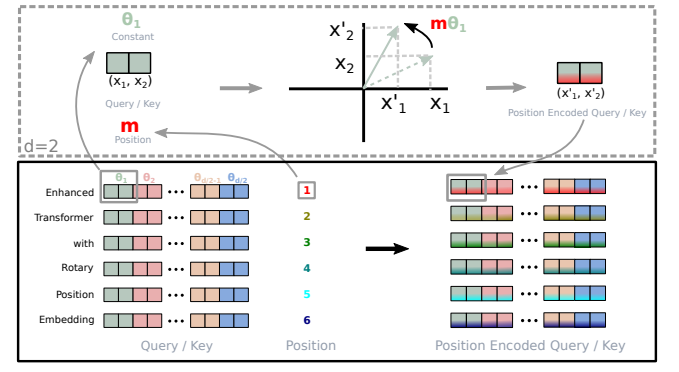

- Shared Input-Output Embeddings – share the input and output embedding matrices

- No Biases – No biases were used in any of the dense kernels or layer norms. This results in increased training stability for large models

- Vocabulary – SentencePiece vocabulary with byte-pair-encoding (BPE) and 256k tokens size. It was chosen to support the large number of languages in the training corpus without excess tokenization. The vocabulary is completely lossless and reversible, which means that whitespace is completely preserved in the vocabulary (especially important for code) and out-of-vocabulary Unicode characters are split into UTF-8 bytes, with a vocabulary token for each byte.

### Training dataset

Consists of a high-quality corpus of 780 billion tokens that represent a wide range of natural language use cases. The dataset is a mixture of filtered webpages,2 books, Wikipedia, news articles, source code, and social media conversations. 

# Language Models for Dialog Applications (LaMDA)

Main idea: standard Transformer model architecture in a decoder-only setup which have up to 137B parameters and is pre-trained on 1.56T words of public dialog data and web text.

### Architechture

- base transformer architechture
- 64 layers 
- d<sub>model</sub> (dimensionality of the representations used as input to the multi-head attention) = 8192
- h (number of heads) = 128
- d<sub>k</sub> (dimensionality of the key embeddings) = d<sub>v</sub> (dimensionality of the value embeddings) = 128
- d<sub>ff</sub> (dimensionality of the feed-forward layer) = 65536
- gated-GELU activation


### Training dataset

The pre-training dataset consists of 2.97B documents, 1.12B dialogs, and 13.39B dialog utterances, for a total of 1.56T words. Over 90% of the pre-training dataset is in the English language. The SentencePiece library is used to tokenize the dataset into 2.81T byte pair encoding (BPE) tokens, with a vocabulary of 32K tokens.

# LLaMA

Main idea: a collection of open-source language models ranging from 7B to 65B parameters, which were trained on trillions of tokens.

### Architechture

- base transformer architechture
- models sizes and optimization hyperparameters:

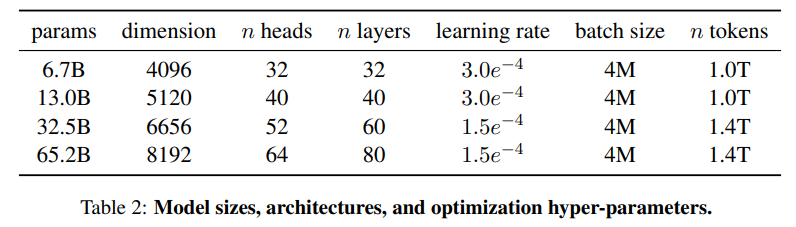

- change attention mechanism: from

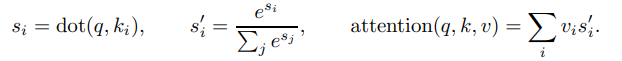

to lazy softmax:

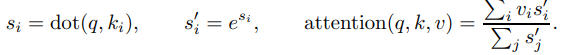

During this algorithm vectors v<sup>\*</sup> and s<sup>\*</sup> are initialized, then they are updated with the rule:





And in the end the final result is obtained by: v<sup>\*</sup> / s<sup>\*</sup>

This algorithm has O(n) memory complexity but still has O(n^2) time complexity for self-attention.

- checkpointing - main idea: cash intermediate results in every layer, so they can be used again during backward pass

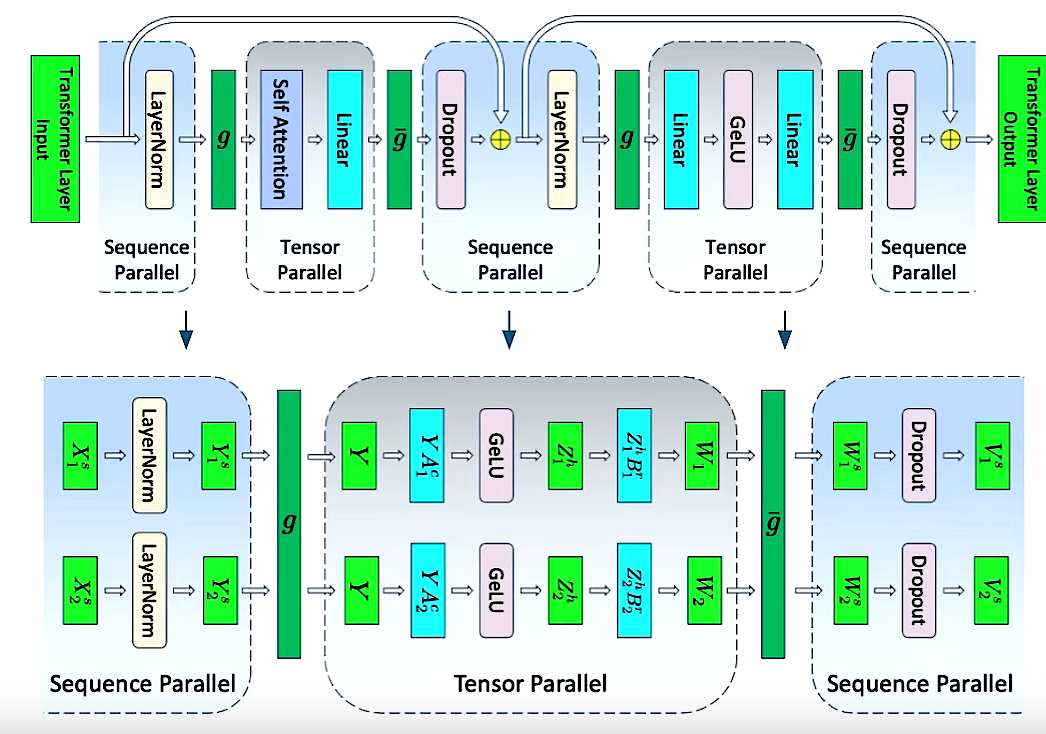

- pre-normalization (GPT3) - normalize the input of each transformer sub-layer, instead of normalizing the output. The RMSNorm normalizing function is used

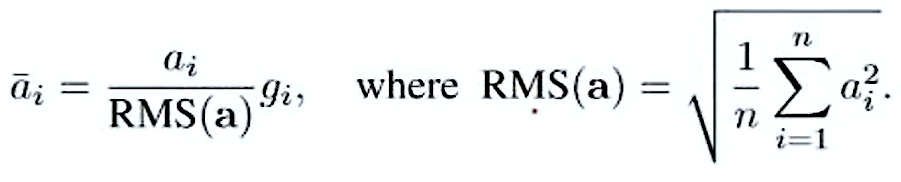

- SwiGLU activation function (PaLM)

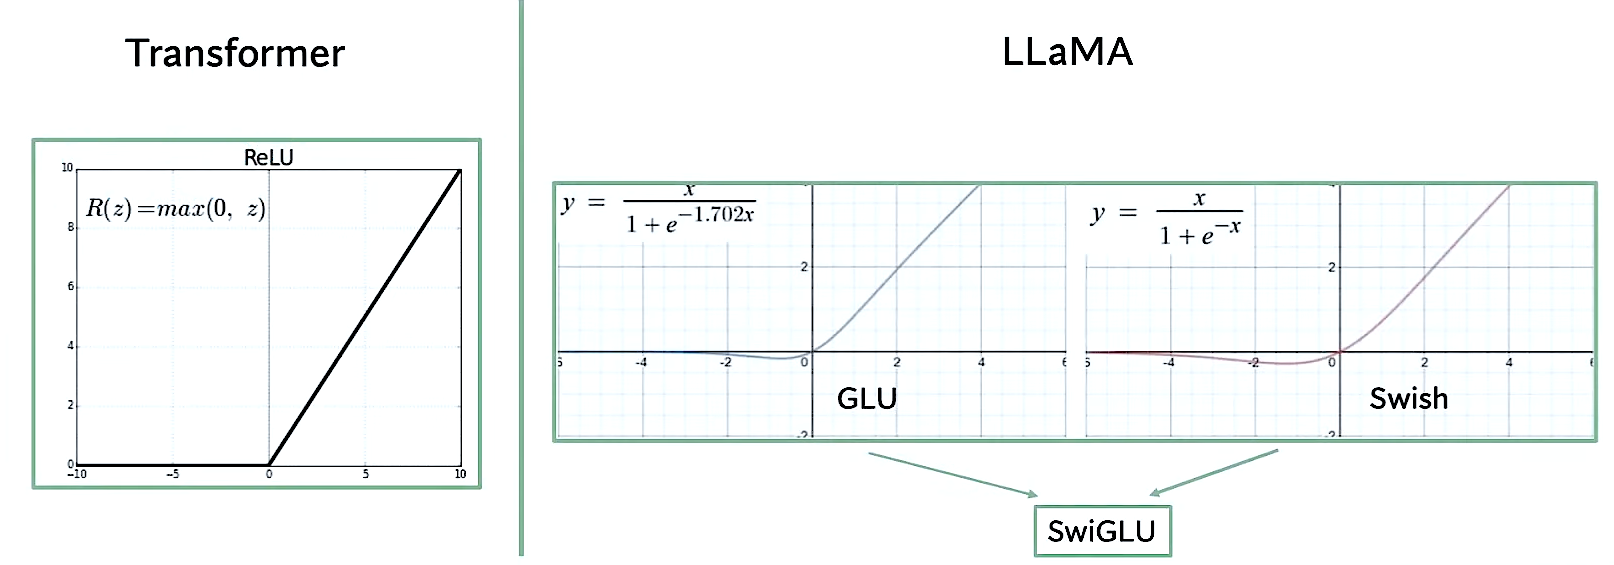

- Rotary Embeddings (RoPE) - look at PaLM for more information
- AdamW optimizer

# Hybrid H3 (Hungry Hungry Hippos)

Main idea: combine State space models (SSMs) with attention mechanism + uses FlashConv - a special hierarchical algorithm for GPU computing and scaling SSMs to billion-parameter models.

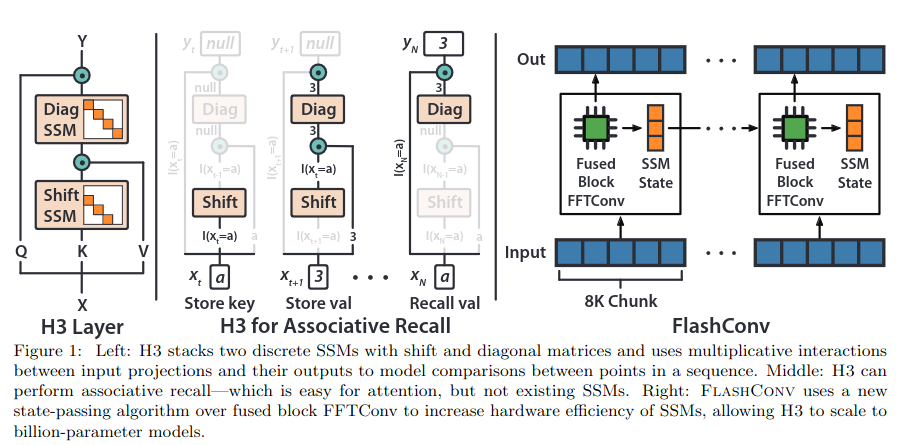

### What is SSM?

#### SSM motivation

Attention is both effective and inefficient because it explicitly does not compress context at all. This can be seen from the fact that autoregressive inference requires explicitly storing the entire context (i.e. the KV cache), which directly causes the slow linear-time inference and quadratic-time training of Transformers. On the other hand, RNNs are efficient because they have a finite state, implying constant-time inference and linear-time training. However, their effectiveness is limited by how well this state has compressed the context. RNNs retain only the previous state, so it can't compress the whole context. SSM was designed to overcome the restrictions of both approaches, especialy for the long range sequences. 

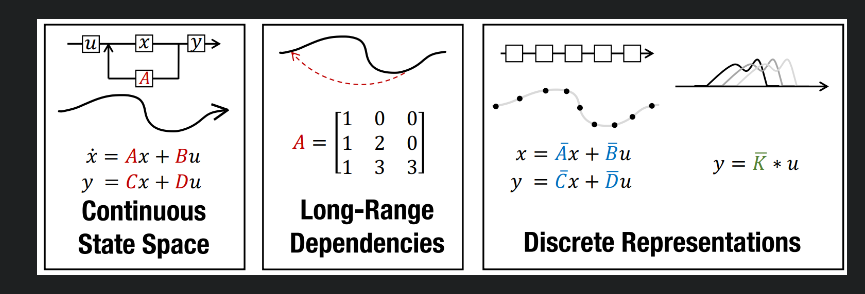

A state-space model (SSM) is a model for very long-range sequence modeling tasks (vision, language, audio) that uses a continuous-time state-space representation that defines a linear mapping from an input signal u(t) ∈ R to an output signal y(t) ∈ R through a state-variable x(t) ∈ R<sup>m</sup>, with the following differential equation:

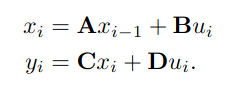

Where 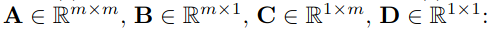 - some matrices

SSM uses these representations as a layer in a deep learning pipeline, where the matrices A, B, C, D are learned from data (e.g., with gradient-based optimization). One often has d of these SSMs in parallel, each corresponding to one hidden dimension. To preserve the sequence history, the history is projected on a basis of orthogonal polynomials (high-order polynomial projection operators - **HiPPO**, more info here https://arxiv.org/pdf/2008.07669.pdf), which translates to SSMs whose A, B matrices are initialized to some special matrices.

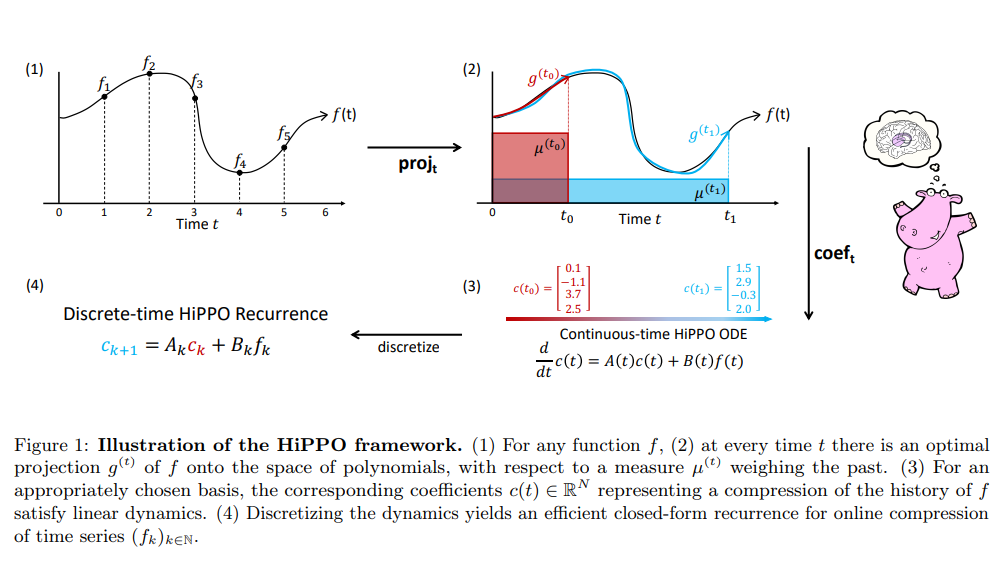

This recurrent form of SSMs allows efficient inference (i.e., generation): to generate the output of the next time-step, one only needs the state of the current time-step, not the entire input history. Furthermore, SSMs can freely extrapolate to sequences longer than seen during training.

Basically, SSM is similar to RNNs but without gates and non-linearities between adjacent states, it's fully linear model.

#### SSM as Convolution

As SSM is a linear model, for efficient training, given the entire sequence of the input u<sub>1</sub>, . . . , u<sub>N</sub> , the output sequence y<sub>1</sub>, . . . , y<sub>N</sub> can also be written as the convolution of the input with the filter:

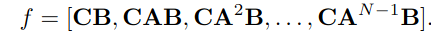

That is, from an initial condition x<sub>0</sub>, we have:



where (f ∗ u) denotes a linear convolution between f and u. If we set the initial condition x<sub>0</sub> to be zero, then y is exactly a linear convolution of u, with a residual connection **D**u. 

Given a 1D input sequence u ∈ R<sup>N</sup> of length N , we denote the 1D output sequence y ∈ R<sup>N</sup> of an SSM parameterized by matrices A, B, C, D as:

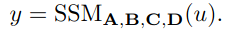

Matrix A is often constrained to be diagonal or sum of diagonal and low-rank matrices, so it's easy to calculate A ** n

##### SSM through FFTs

Computing the convolution naively through conventional matrix operations is expensive for long kernels, scaling as O(N**2). Instead, we can use FFTs: take the FFT of f and u, multiply them together pointwise, and then take the inverse FFT. This yields an O(N log N) algorithm.

At first SSM was used in the **Structured State Space for Sequence Modeling (S4)**, more info here https://srush.github.io/annotated-s4

### H3 Layer

H3 is loosely inspired by linear attention, that looks like:

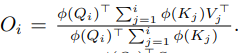

Main point of linear attention is in replacing of function Sim(Q, K) that has O(N^2) complexity in classic attention with φ(K)<sup>T</sup> φ(K) for some (nonlinear) function φ. All terms of linear attention equation can be incrementally updated (as cumulative sums).

In H3 we project the input *u* to get three matrices Q, K, V. Then we replace the non-linear function φ(K) with an SSM with shift A (SSM<sub>shift</sub>), and we replace the summation 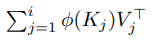 with an SSM with diagonal A (SSM<sub>diag</sub>).

H3 Layer contains:
- shift matrix SSM<sub>shift</sub> that shifts the elements of a state vector x<sub>i</sub> (e.g.,mapping [a, b, c] → [0, a, b]). The action of this matrix on the hidden state x<sub>i</sub> is to shift each coordinate down by one — thereby creating a “memory” of the previous states. For example, if B = e1, the first basis vector, then xi = [Ui, Ui−1, . . . , Ui−m+1] contains the inputs from the previous m time steps.
- diagonal matrix SSM<sub>diag</sub> that allows model to remember states x<sub>i</sub> over the entire sequence

The entire layer with Q, K and V matrices looks like

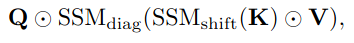

The shift SSM can detect when a particular event occurs, and the diagonal SSM can remember a token afterwards for the rest of the sequence. Their combination provides capability of comparing tokens across the sequence.

### H3 Layer algorithm

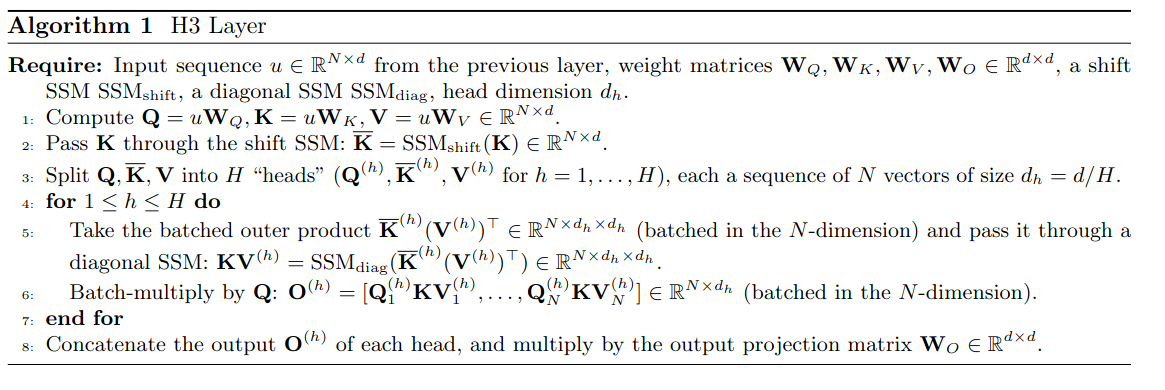

H3 scales as O(N log N ) with sequence length N and hidden dimension size d — asymptotically more efficient than attention, which typically requires O(N^2 * d) time and O(N^2) space.

### FlashConv algorithm

FlashConv consists of two parts:

- *FFTConv* that speeds up the FFT-based convolutions (which is used to speed SSM computation)

- *State-Passing algorithm* that splits the FFTConv of a length-N sequence into chunks of size N′ each (N′ is the longest FFT we can fit into GPU SRAM, analog of processor cache). We use FFTConv to compute each chunk and use a recurrence to connect the chunks. Thus GPU can compute FFT even for a huge sequences that doesn't fit into the GPU memory.

### Hybrid H3: result

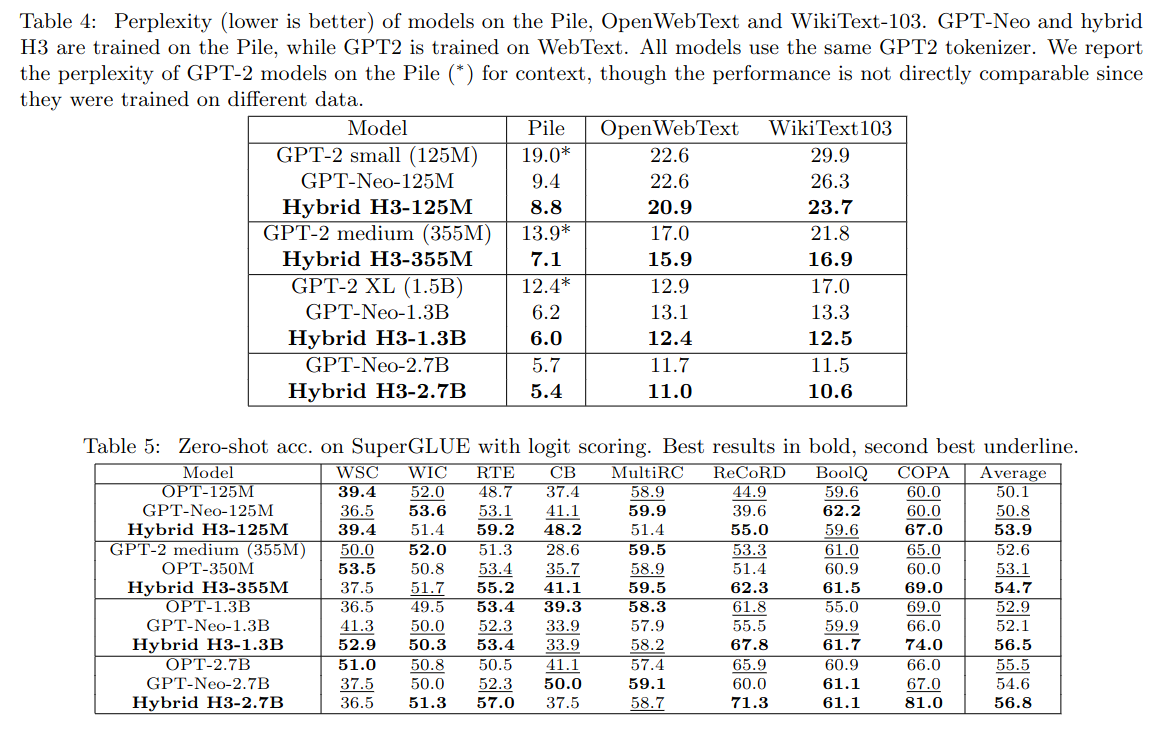

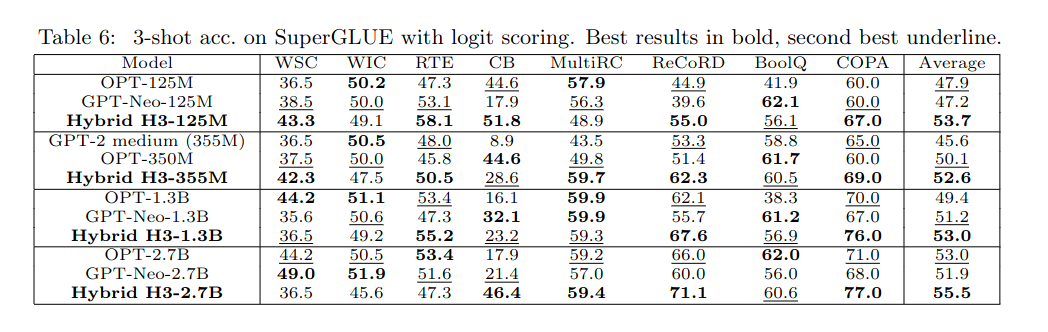

# Mamba

Main idea: combine the design of prior SSM architecture with the MLP block of Transformers into a single block

But vanilla SSM (S4) can't solve tasks like Selective Copying of Induction Heads.

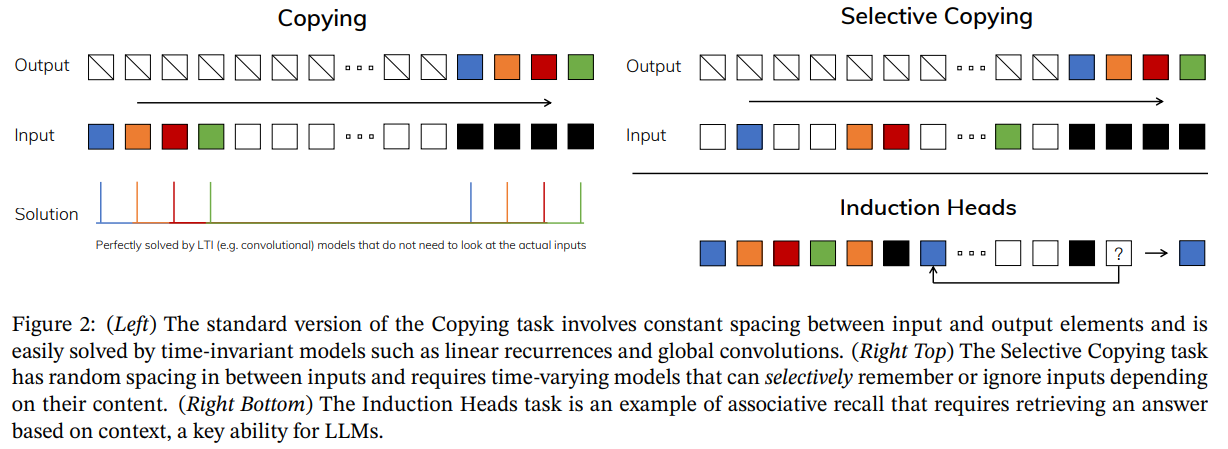

### SSM + Selection mechanism = Selective SSM (S6)

So, to make model solve tasks like these, SSM from S4 was changed to SSM + Selection (S6). The main idea was in making some parameters of SSM (Δ, B, C) input dependent. In particular, we highlight that these parameters now have a length dimension L. Algorithm changes can be seen below:

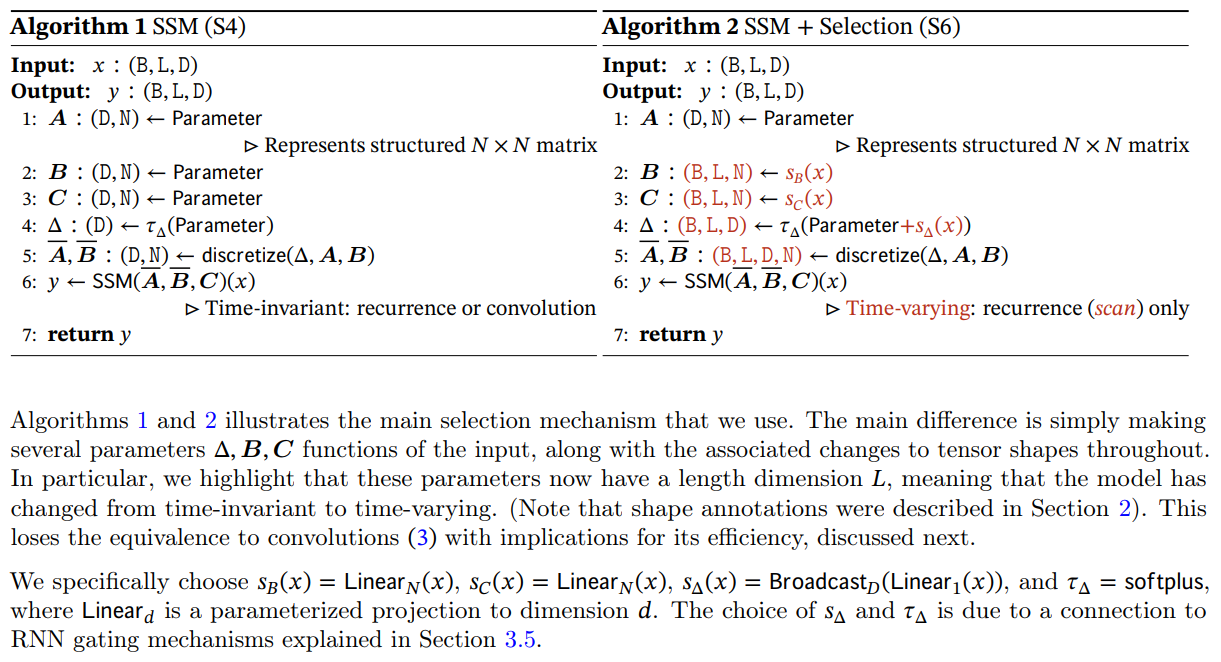

Where B - batch size, L - sequence length, D - number of channels, N - size of A, B, C matrices: 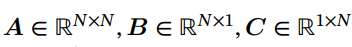

Softplus is an activation function log(1 + e^x), this activation function is a smooth continuous version of ReLU. Δ is used to transform the “continuous parameters” (A, B) to “discrete parameters”.

#### Interpretation of S6 matrices

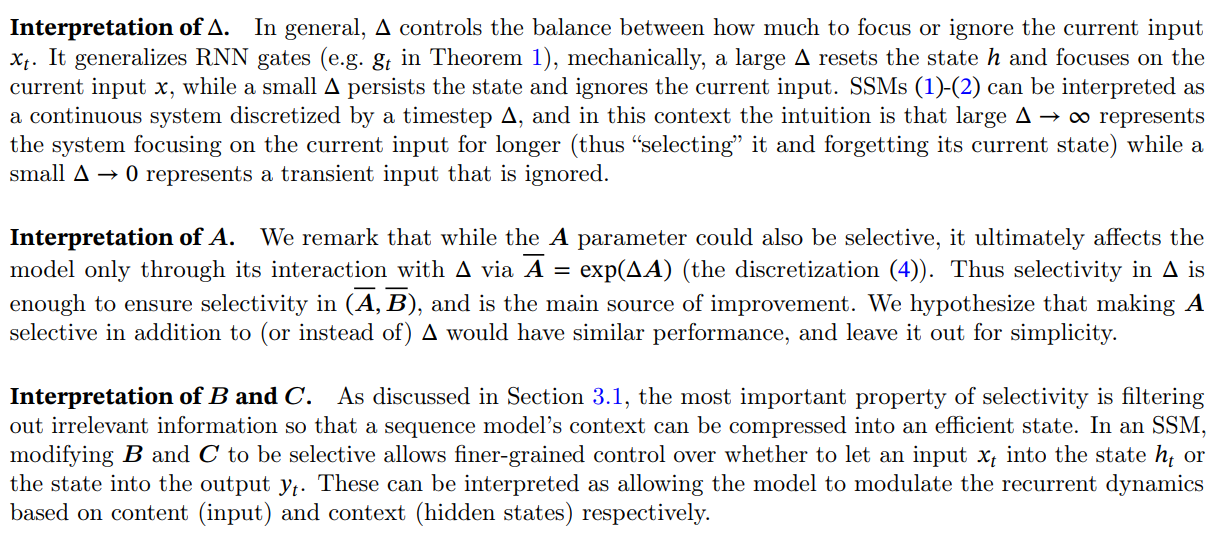

### Architechture

Overview of Mamba block

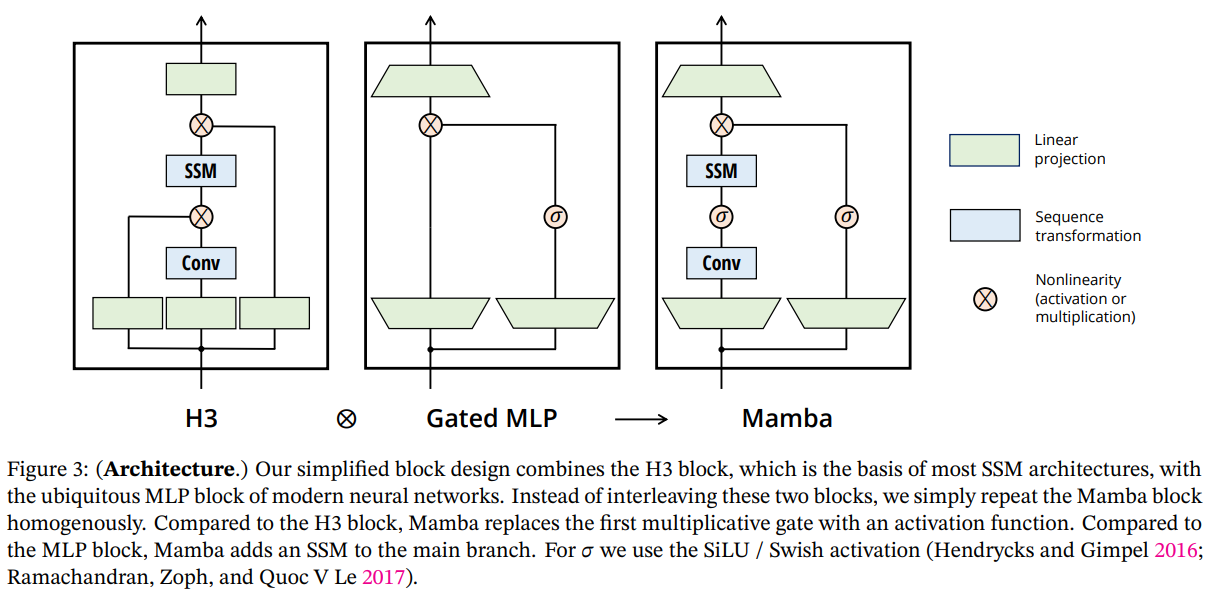

This block is repeated, interleaved with standard normalization and residual connections, to form the Mamba architecture.

### Effective Selective SSM calculation

Because now matrices Δ, B, C are input dependent and have an additional dimension L, effective way of calculation of these parameters is needed. In this model instead of preparing the scan input (A, B) of size (B, L, D, N) in GPU HBM, the SSM parameters (∆, A, B, C) are loaded directly from slow HBM to fast SRAM, then the discretization and recurrence are performed in SRAM, and final outputs of size (B, L, D) are written back to HBM.

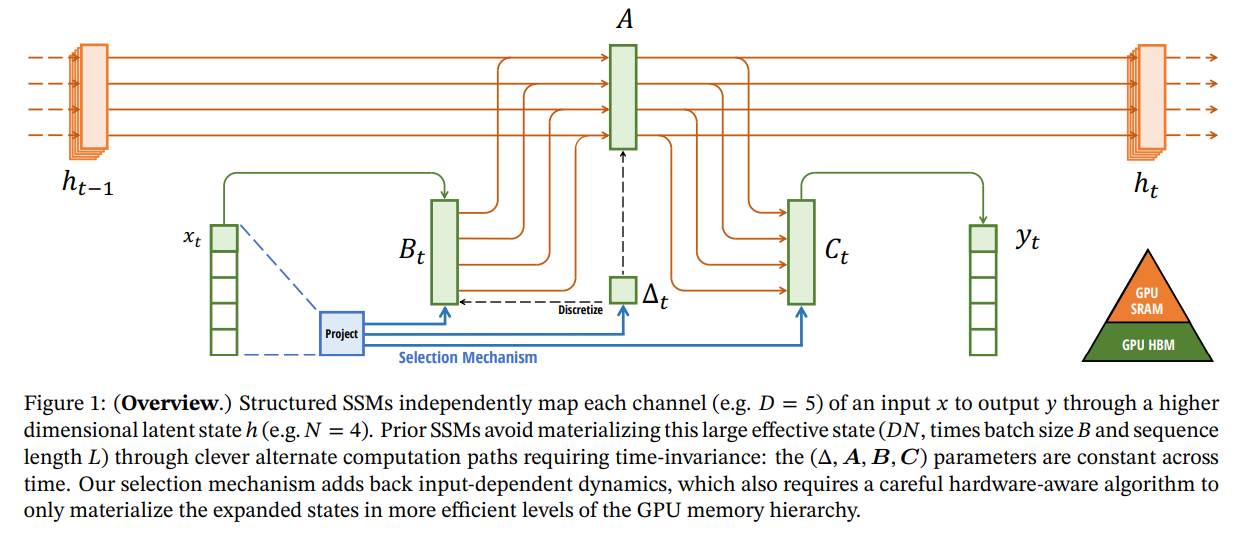

### Results

#### Selective Copying and Induction Heads

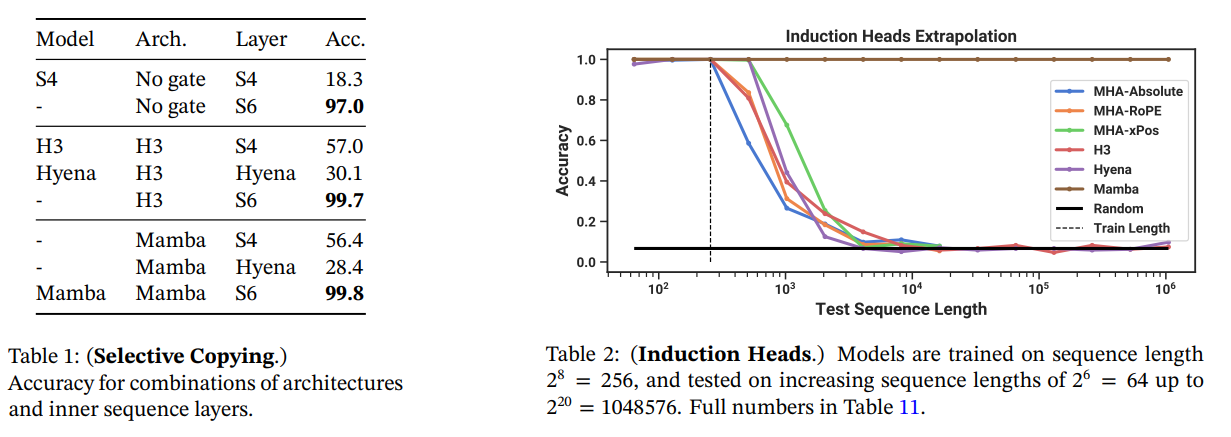

#### Language modeling

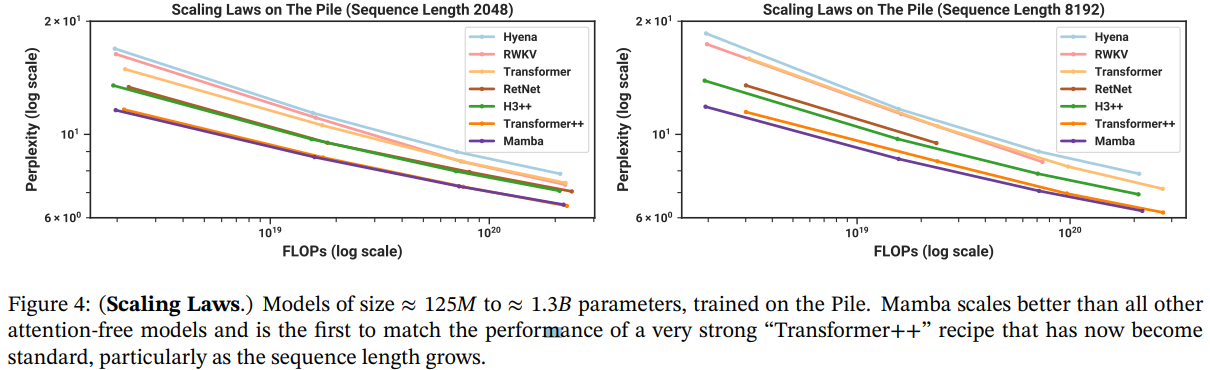

Perplexity is calculated as

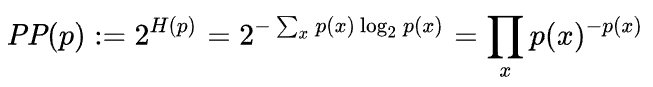, where H(p) is an entropy, so the lower perplexity the better.

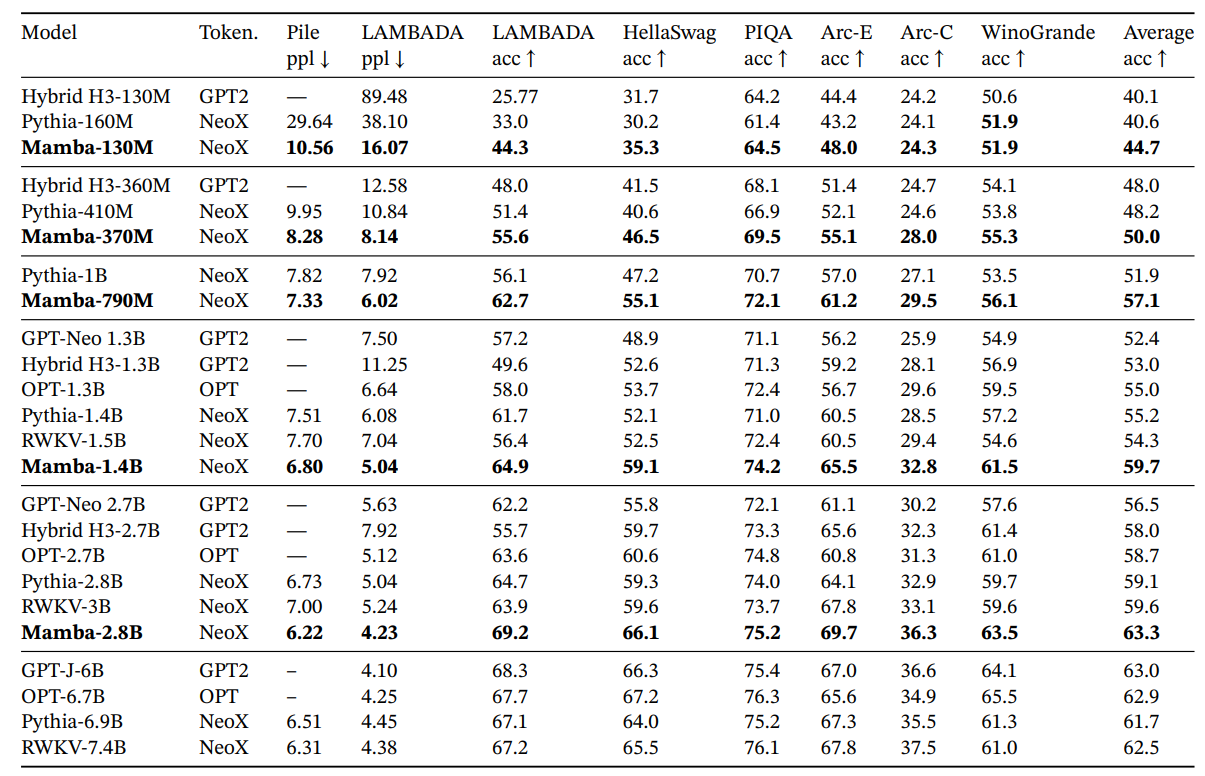

#### Speed and Memory Benchmarks

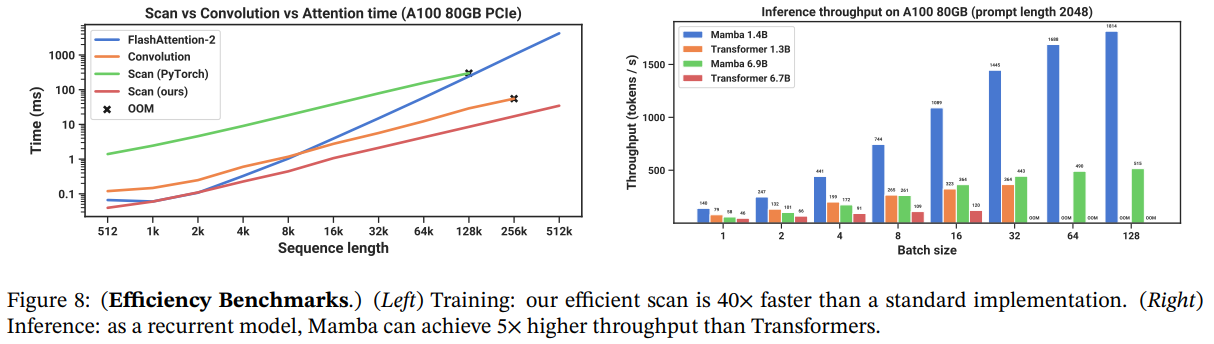

# Mixtral

Main idea: a high-quality sparse mixture of experts model (SMoE) with open weights. 

Mixtral is a sparse mixture-of-experts network. It is a decoder-only model where the feedforward block (a block where transformer stores it's knowledge - look at transformer architecture) picks from a set of 8 distinct groups of parameters. At every layer, for every token, a gating (router) network chooses two of these groups (the “experts”) to process the token and combine their output additively.

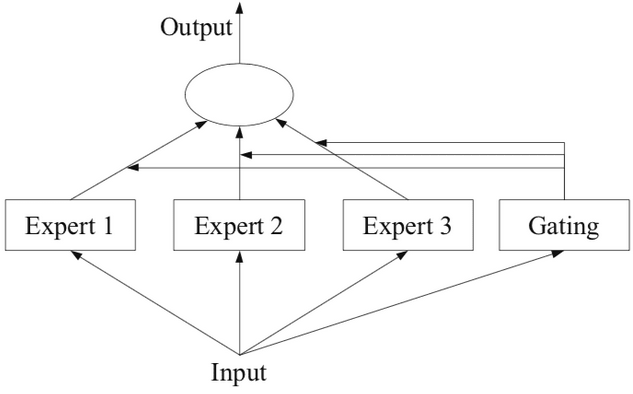

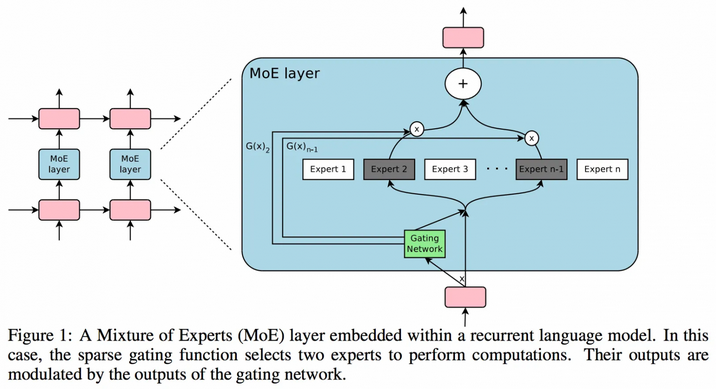

This technique increases the number of parameters of a model while controlling cost and latency, as the model only uses a fraction of the total set of parameters per token. Concretely, Mixtral has 46.7B total parameters but only uses 12.9B parameters per token. It, therefore, processes input and generates output at the same speed and for the same cost as a 12.9B model.

Mixtral is pre-trained on data extracted from the open Web – we train experts and routers simultaneously.


Mixtral has the following capabilities.

- gracefully handles a context of 32k tokens.
- handles English, French, Italian, German and Spanish.
- shows strong performance in code generation.

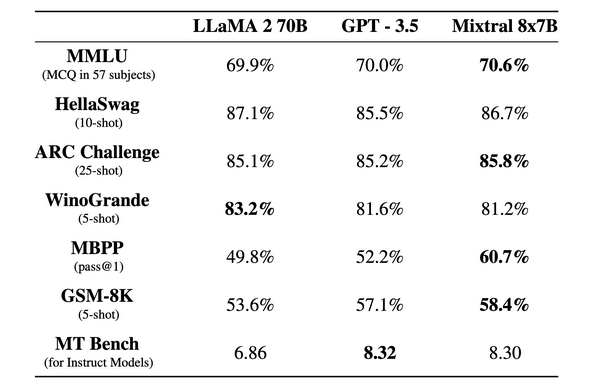

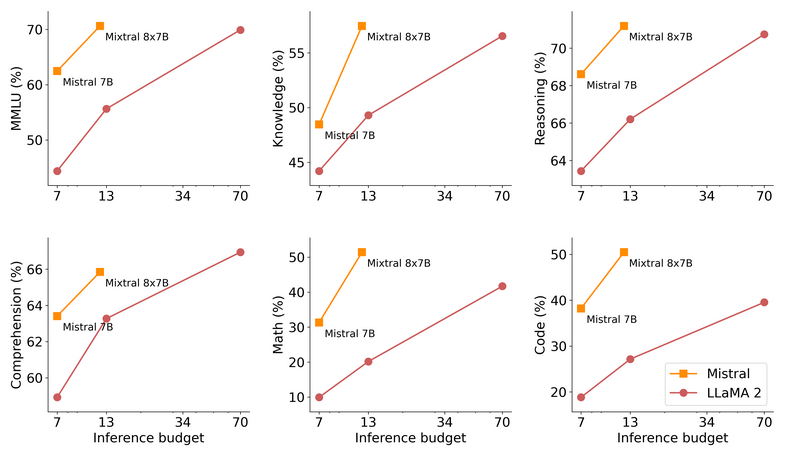

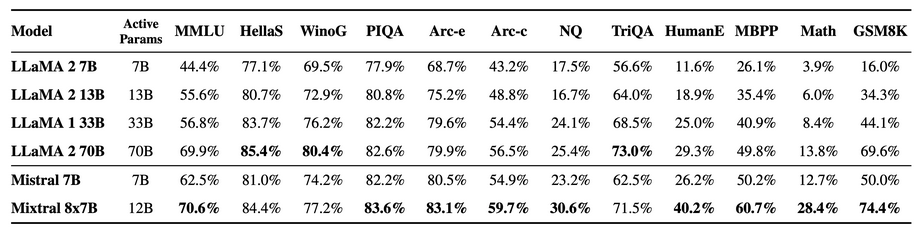

# Effective transformers: Low Rank Adaptation (LoRA)

It's very hard to finetune the LLMs and other generative models like GANs or Diffusion Models because of their size. Even the last layer is sometime too heavy for an ordinary computer. LoRA is the way of simple model finetuning and quickly changing the style of its response. 

Main idea: let's consider the last level of the model *W*, the output of the model can obtained as *y = Wx*. We want to change the output of this layer by finetuning the model weights. It can be done this way:

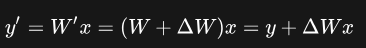

As we can see, new layer is W + ΔW and ΔW can be interpreted as one more FC layer.

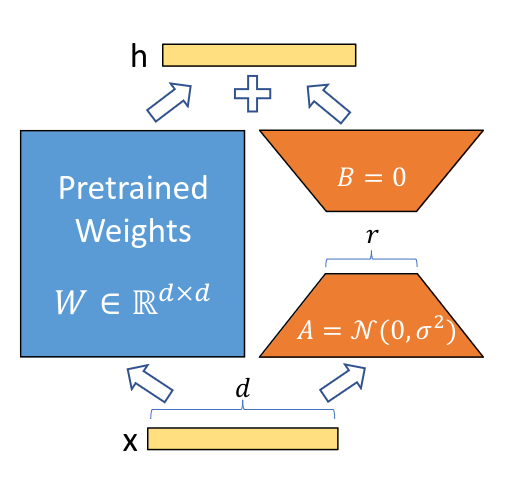

But the problem is that *ΔW* has the same size as *W*, so we can't decrease the number of trainable parameters and training of this layer is as heavy as training of the last layer *W*.

Here's where Low Rank enters the game - matrix of the low rank can be transformed to 2 matrices of lower dimensiality. Let's suppose that our matrix has size 70x100. If its rank *r* is low (e.g. 2) it can be transformed to two matrices *B* and *A* of size 70x2 and 2x100

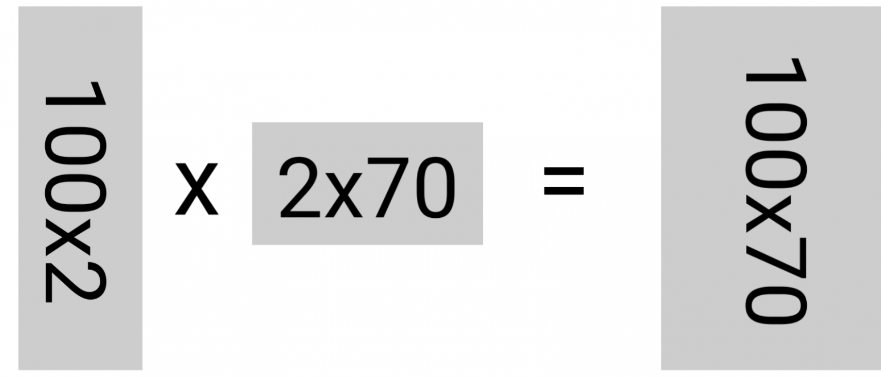

That's how we decrease the number of parameters - first matrix has 7000 parameters while these two matrices have 200 + 140 = 340 parameters. In general (for the square matrix) the number of parameters can be decreased in *(nr + nr) / n^2 = 2r / n* times. We select *r* to be low (2-8).

Because of the low rank model performance theoretically can decrease. However, there is nothing to worry about, LoRA developers claim that the "intrinsic rank" of large text models is very low, and most parameters "don't work". Thus, during training, we need to store the weights W in memory and ΔW = B * A and calclulate the gradients only for these two small matrices.

We use a random Gaussian initialization with zero mean for A and zeros for B, so ∆W = BA is zero at the beginning of training.

### Advantages of the LoRA

- decrease the number of trainable parameters which leads to speeding-up of the training process and decreasing of memory consumption

- we can precalculate *W` = W + BA* and thus the new model demands the same number of computation as original model

- we can change matrices A and B in the middle of a dialogue, asking the user, for example, in what style to answer him/her.

We can additionally decrease A and B matrices size by using of the quantization like int8 or int4. It leads to decreasing of the model performance but it's not huge because the majority of NN weights lie near 0. This way we allocate more "levels" closer to the origin, and fewer further away.

# DeepSeek v2

Main idea: a large MoE language model that supports 128K context length. In addition to strong performance, it is also characterized by economical training and efficient inference, benefiting from its innovative architecture including Multi-Head Latent Attention (MLA) and DeepSeek Mixture of Experts (MoE). 

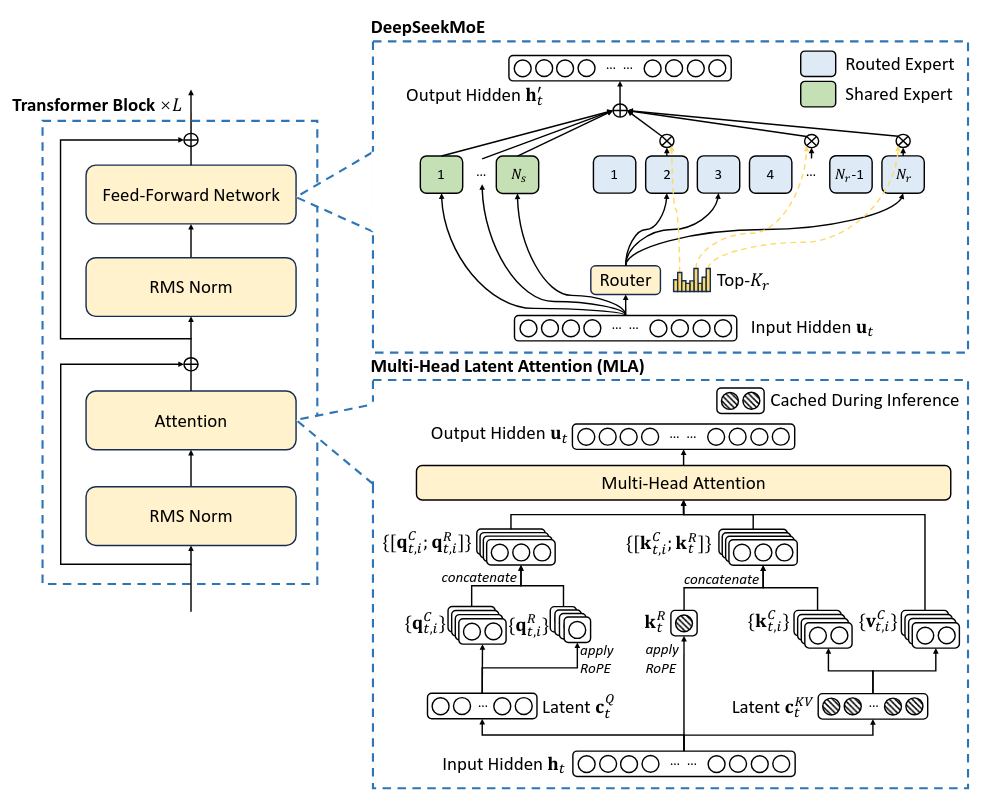

### MLA vs Grouped Query Attention (GQA) vs Multi Query Attention (MQA)

Main idea: use special down-projection matrix W<sup>DKV</sup> to compress input vector. Then to get key and values matrices we use matrices W<sup>UK</sup> and W<sup>UV</sup> respectively. Same technique is used for query matrix. All of these matrices are low rank and only compressed vector is cached during inference, so that helps to reduce memory significantly.

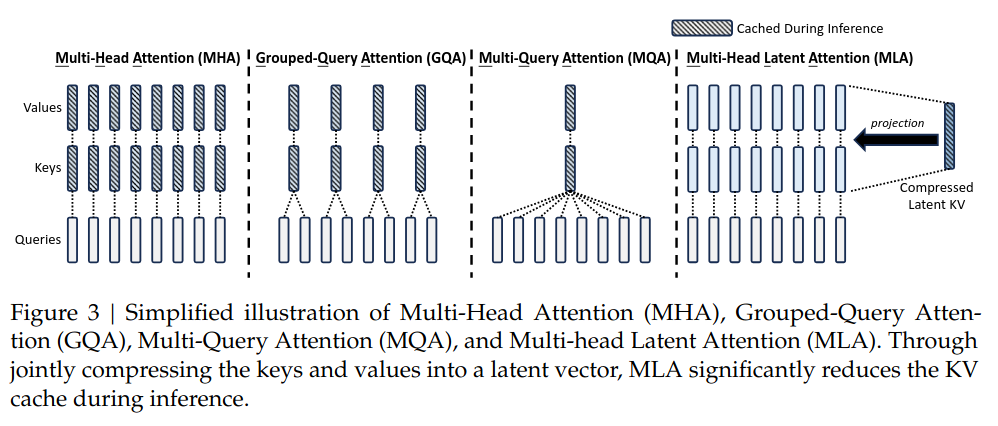

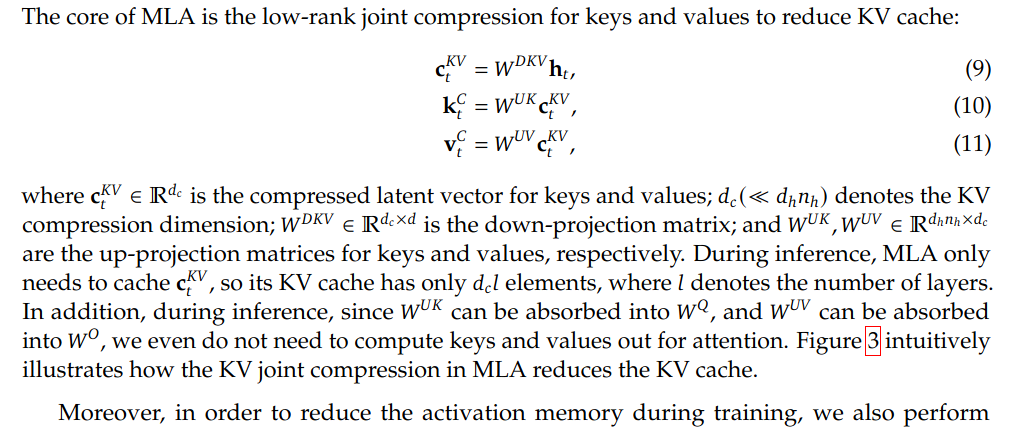

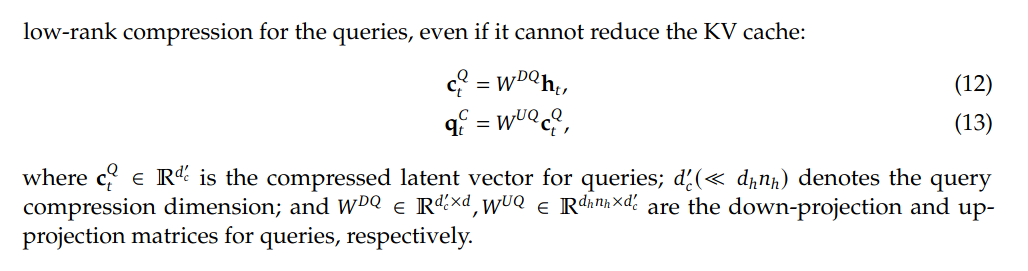

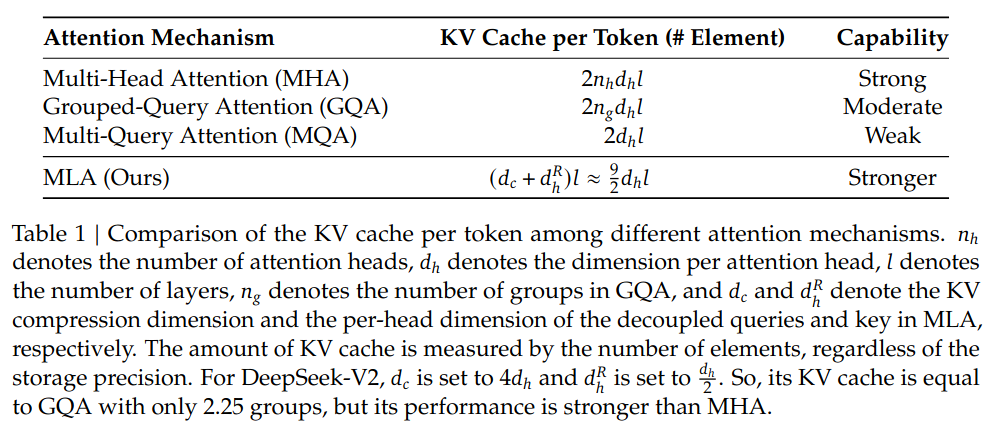

### Decoupled Rotary Position Embedding

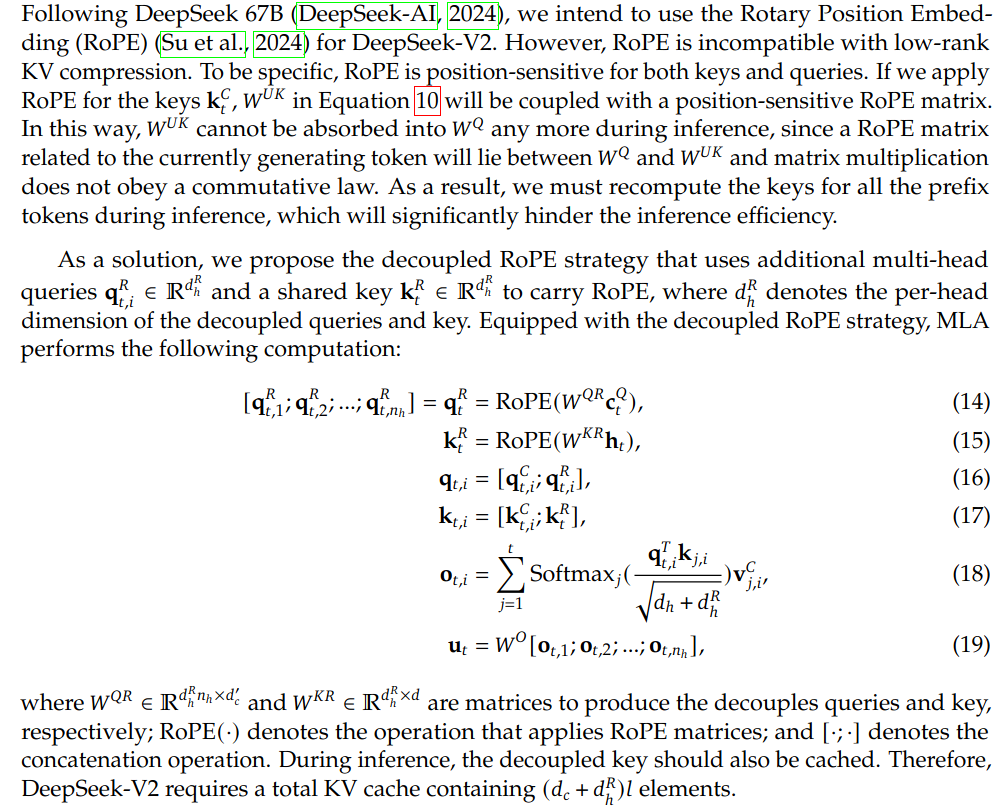

### MOE

Main idea: 
- segmenting experts into finer granularity for higher expert specialization and more accurate knowledge acquisition
- isolating some shared experts for mitigating knowledge redundancy among routed experts

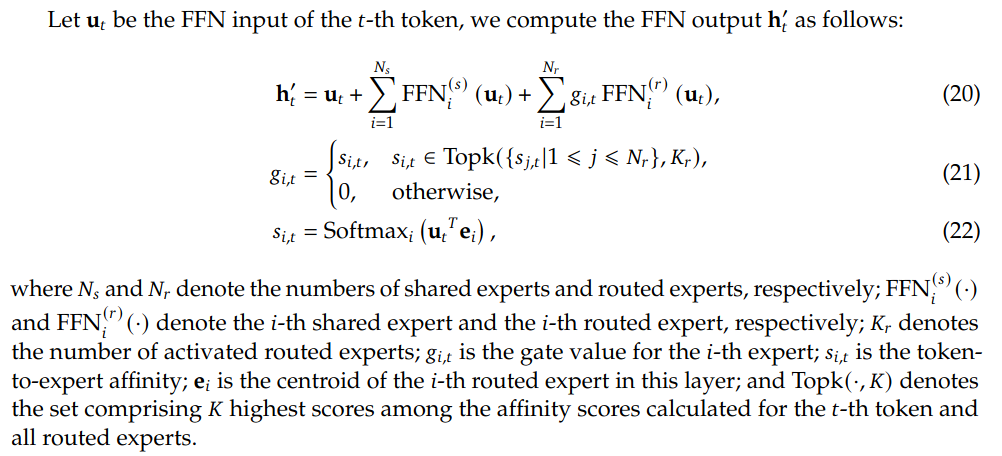

In other words, some of experts (routed experts) are used only if their affinity score for i-th token is high enough and in top K of affinity scores among other experts.

### Losses

Three different losses are used for controlling expert-level load balance, device-level load balance, and communication balance.

#### Expert-level balance loss

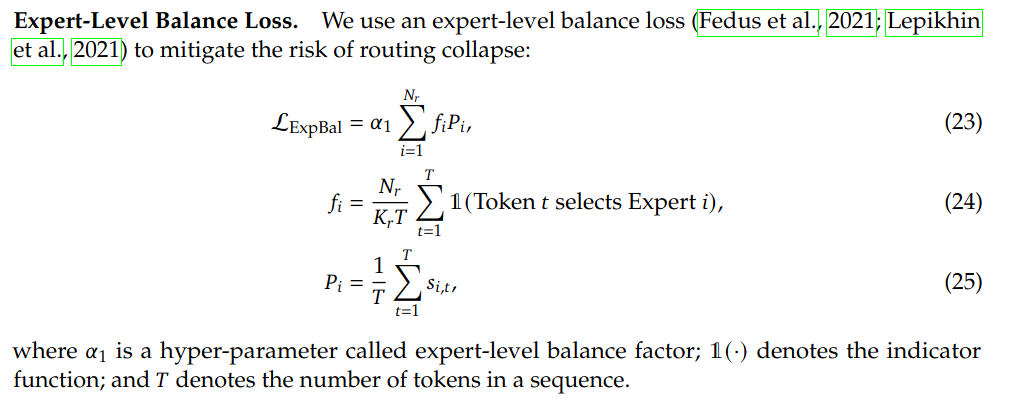

#### Device-level balance loss

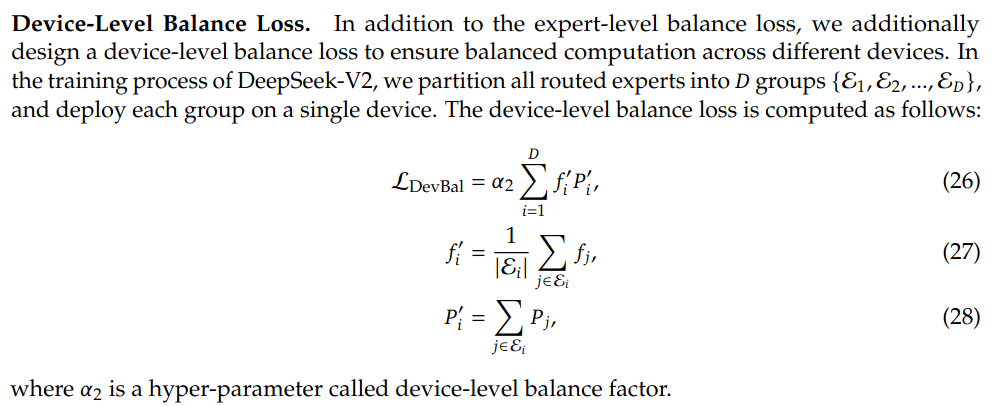

#### Communication-level balance loss

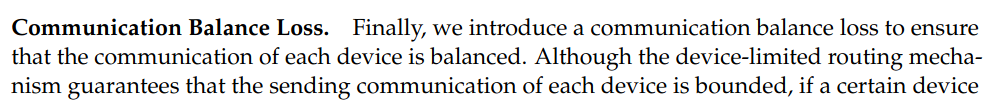

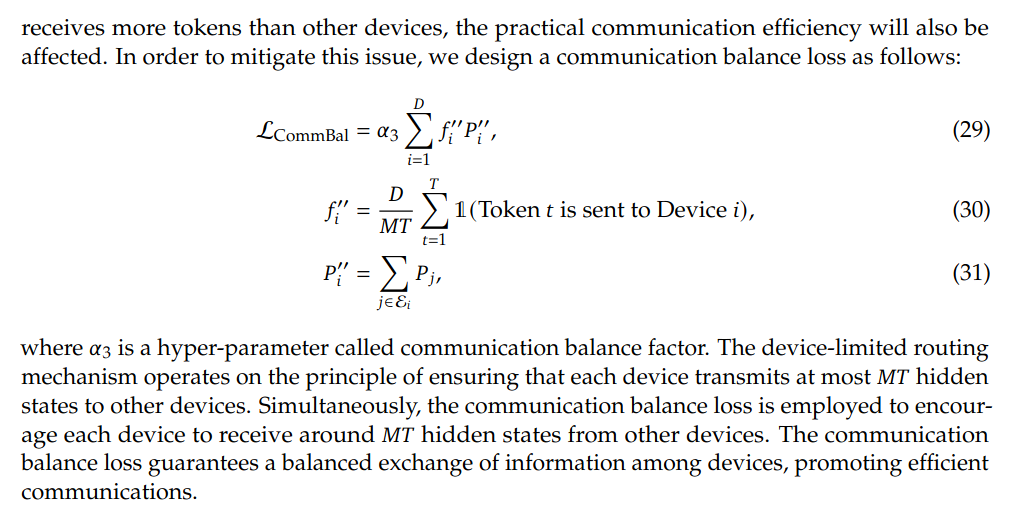

### Token-Dropping Strategy

While balance losses aim to encourage a balanced load, it is important to acknowledge that they cannot guarantee a strict load balance. In order to further mitigate the computation wastage caused by unbalanced load, we introduce a device-level token-dropping strategy during training. This approach first computes the average computational budget for each device, which means that the capacity factor for each device is equivalent to 1.0. Then we drop tokens with the lowest affinity scores on each device until reaching the computational budget. In addition, we ensure that the tokens belonging to approximately 10% of the training sequences will never be dropped. In this way, we can flexibly decide whether to drop tokens during inference according to the efficiency requirements, and always ensure consistency between training and inference.

# Effective transformers:  DuoAttention

Main idea: attention complexity is O(n<sup>2</sup>). But attention heads in LLMs can be categorized into two distinct types: Retrieval Heads and Streaming Heads. Retrieval Heads, which represent only a fraction of the total, are crucial for processing long contexts and require full attention across all tokens. In contrast, the majority of attention heads, termed Streaming Heads, primarily focus on recent tokens and attention sinks, and can operate effectively with a reduced KV cache that includes only recent tokens and attention sinks.

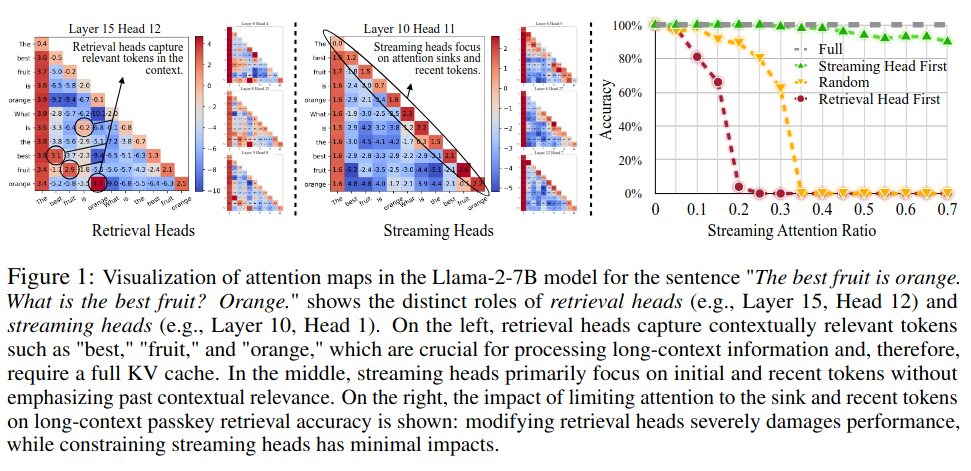

DuoAttention directly measures output deviation resulting from token dropping, achieving higher compression rates and improved deployment efficiency. Each DuoAttention Transformer layer has two KV caches— a full KV cache for crucial retrieval heads and a constant KV cache for streaming heads, which stores only attention sinks and recent tokens. This design allows DuoAttention to dramatically reduce memory usage and improve decoding speed in models like Llama-2/3 and Mistral, achieving up to **2.55×** for MHA (Mutli-Head Attention) and **1.67×** for GQA (Grouped Query Attention) models while speeding up decoding by up to **2.18×** and **1.50×** and accelerating pre-filling by up to **1.73×** and **1.63×** for MHA and GQA models, respectively, with minimal accuracy loss compared to full attention.

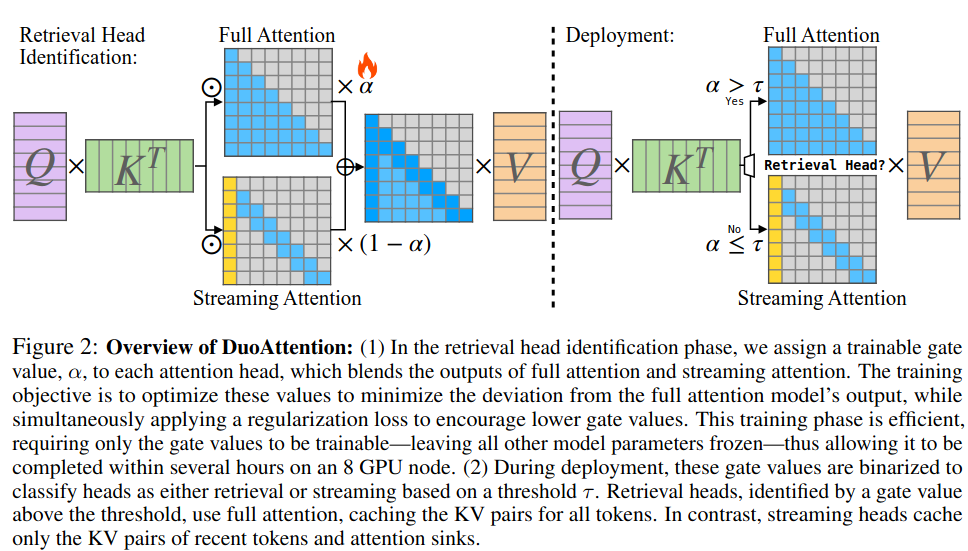

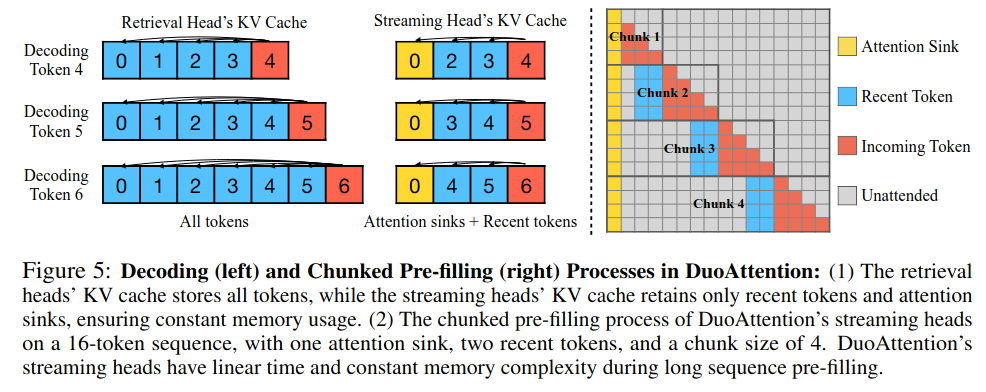

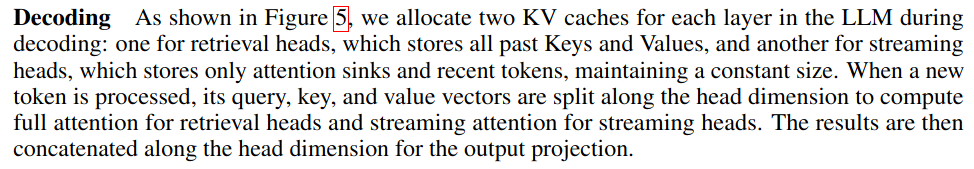

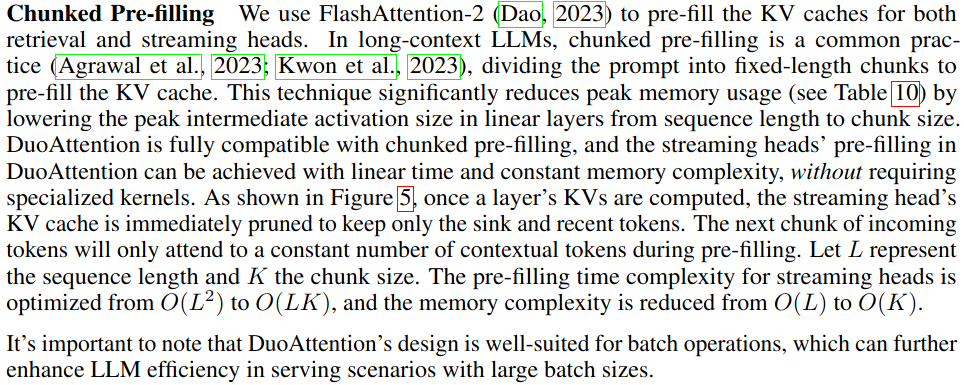

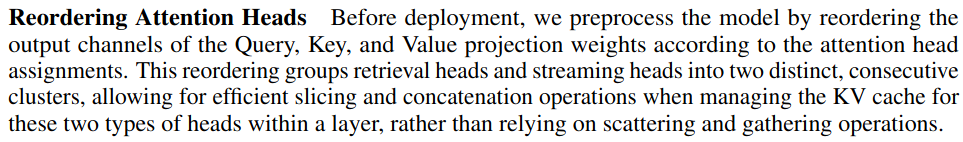

A syntetic dataset is used to find out which heads are streaming and which heads are retrieval.

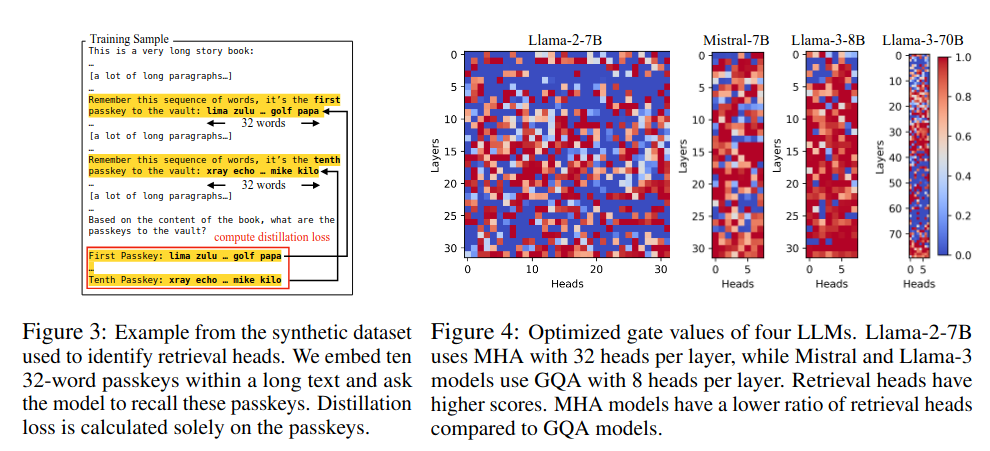

### Training and Loss Function

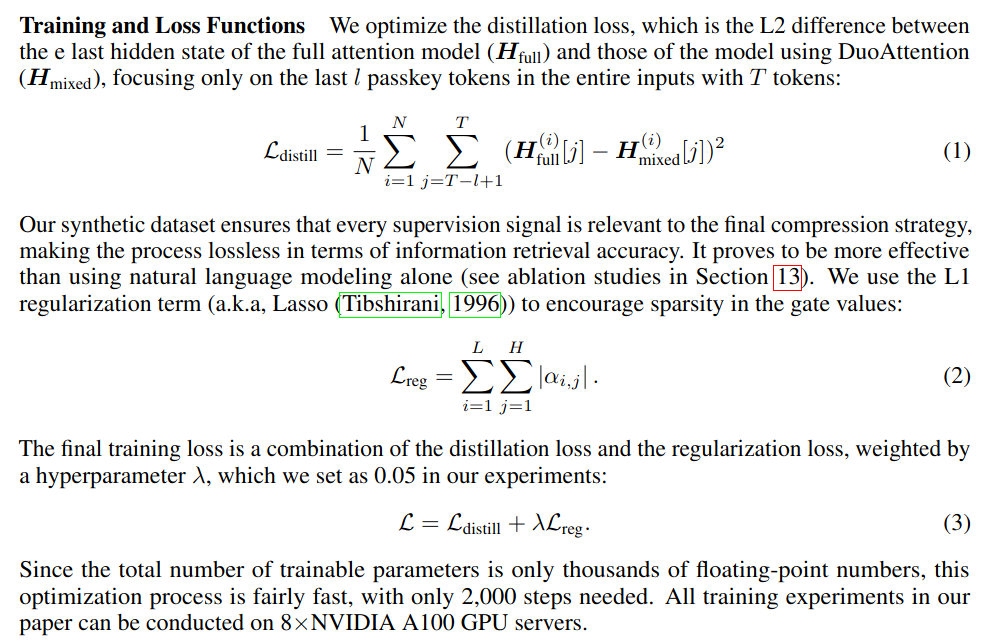

### Results

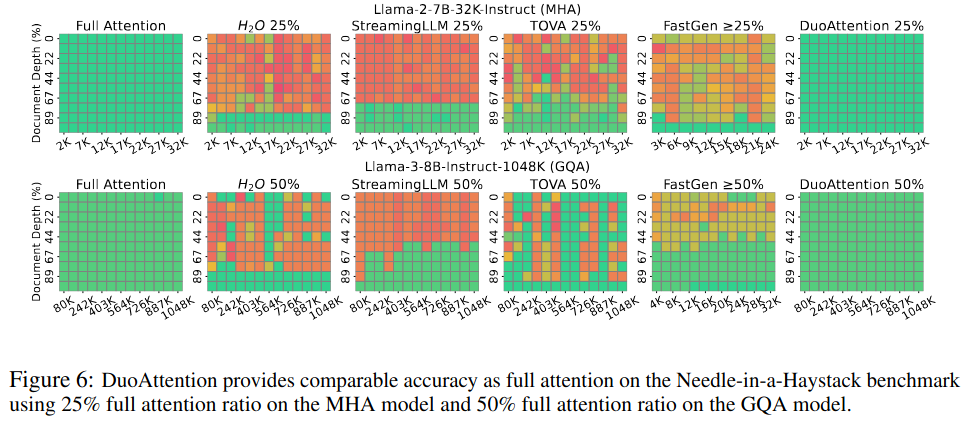

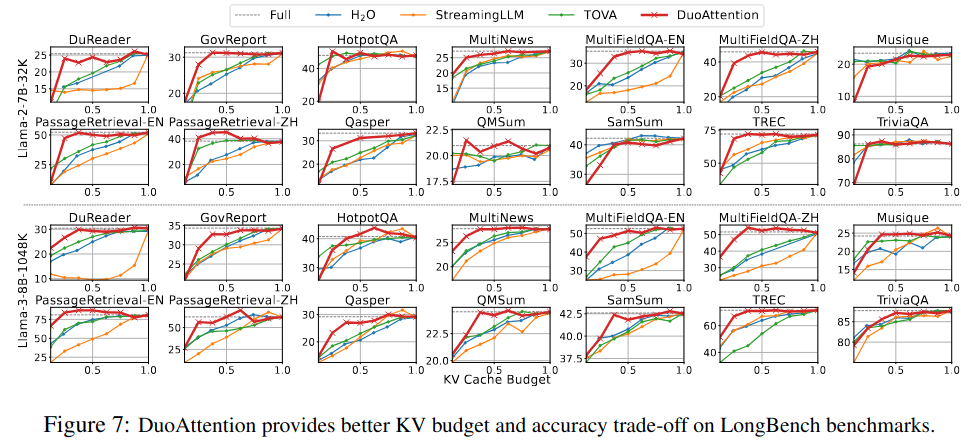

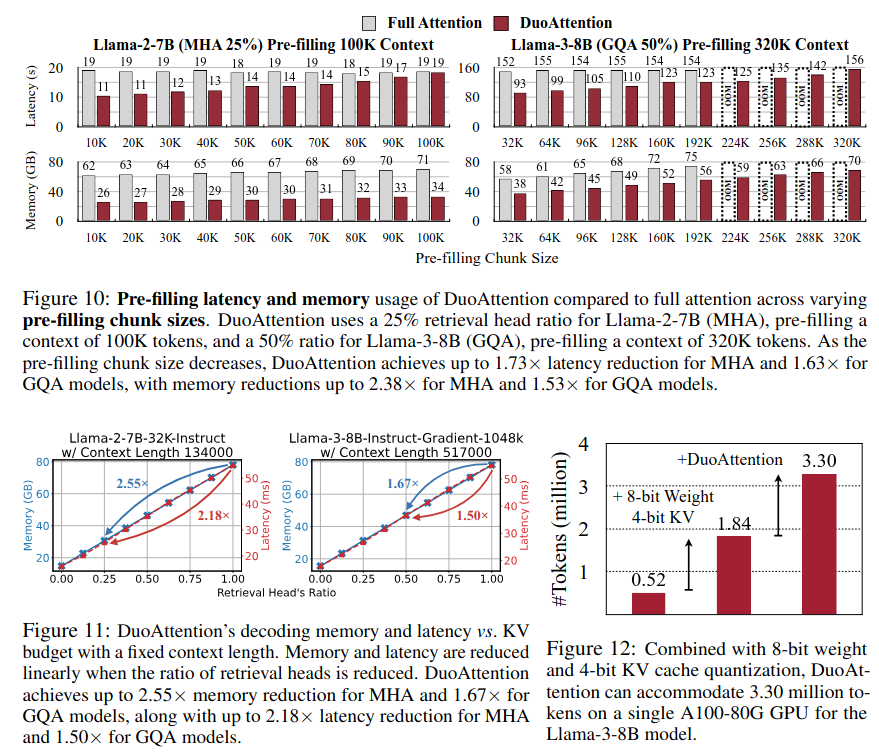